In [1]:
from river import datasets
from river import evaluate
from river import metrics
from river import preprocessing
from river import forest
from river import stream
from river import ensemble
from river import tree
from river.drift import ADWIN, KSWIN, PageHinkley

In [2]:
# %pip install -U pandas numpy tqdm matplotlib seaborn scikit-learn river ipywidgets optuna plotly nbformat jupyter-dash

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import datetime

In [5]:
PROJECT_ROOT                     = "../"
ARTIFACTS                        = "./artifacts/"
TIMESTAMP                        = datetime.datetime.now().isoformat()

SOURCE_DATASET_ROOT              = PROJECT_ROOT + "datasets/isp3/"

SOURCE_DATASET_FILENAME          = SOURCE_DATASET_ROOT + "[dvwa.isp_xvwa.isp]_https_apache.csv"
SOURCE_DATASET_FILENAME_D        = SOURCE_DATASET_ROOT + "[dvwa.isp]_https_apache.csv"
SOURCE_DATASET_FILENAME_X        = SOURCE_DATASET_ROOT + "[xvwa.isp]_https_apache.csv"
# SOURCE_DATASET_TRAIN_FILENAME    = SOURCE_DATASET_ROOT + "DataSetN_Train.csv"
# SOURCE_DATASET_TEST_FILENAME     = SOURCE_DATASET_ROOT + "DataSetN_Test.csv"

# Подготовка датасета

In [6]:
df = pd.read_csv(SOURCE_DATASET_FILENAME)
df['Label'].value_counts()

/tmp/ipykernel_2887070/3322869287.py:1: DtypeWarning: Columns (3,103,121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(SOURCE_DATASET_FILENAME)


Label
Web Attack - DDoS                 65295
Benign                             4446
Web Attack - XSS                   2686
Web Attack - SQL Injection         1483
Web Attack - Command Injection     1400
Web Attack - Brute Force            497
Web Attack - Web Shell              353
Web Attack - CSRF                    60
Name: count, dtype: int64

In [7]:
excluded = ['Flow_ID', 'Source_IP', 'Source_Port', 'Destination_IP', 'Destination_Port', 'Protocol', 'Timestamp', "Unnamed: 0", "xvwa.isp", "Label", "dvwa.isp"]
df = df.drop(columns=excluded, errors='ignore')

In [8]:
excluded2 = ['Session_Index',  'Target','Http_Reqest','Root','GlobalLabel','Type','Tools','ToolsThreads','ToolsDelay','ToolsAdditional',
             'ChannelSpeedBefore','ChannelSpeedAfter','NetemString','Server','KeepAliveTimeout','TargetProtocol','File','SessionAnalizerMode']
df = df.drop(columns=excluded2, errors='ignore')

In [48]:
webattack_features = ['Flow_ID', 'Flow_Duration',
 'Total_Fwd_Packets',
 'Fwd_Packet_Length_Max',
 'Bwd_Packet_Length_Max',
 'Flow_Bytes_s',
 'Flow_Packets_s',
 'Flow_IAT_Min',
 'Fwd_IAT_Min',
 'Bwd_IAT_Mean',
 'Bwd_IAT_Std',
 'Bwd_IAT_Min',
 'Packet_Length_Variance',
 'Fwd_FIN_Flags',
 'Fwd_SYN_Flags',
 'Fwd_RST_Flags',
 'Bwd_FIN_Flags',
 'Stream_Session_Number',
 'Stream_Was_Prev_Session',
 'Stream_Was_Next_Session',
 'Stream_Session_Intervals_Min_Duration',
 'Stream_Session_Intervals_Std_Duration',
 'Stream_Session_Durations_Min_Duration',
 'Stream_Session_Durations_Max_Duration',
 'Fwd_Bandwidth_Max',
 'Bwd_Bandwidth_Min',
 'Bwd_Bandwidth_Max']

In [10]:
def prepare_dataset(name, train_size=0.2, test_size=0.8):
    df = pd.read_csv(name)
    df['Label'].value_counts()

    label_rows = df[df['Label'] == 'Web Attack - DDoS']
    rows_to_remove = label_rows.sample(frac=0.94, random_state=42)
    df = df.drop(index=rows_to_remove.index)
    df['Label'].value_counts()
    
    attacks = {
        'Web Attack - XSS',
        'Web Attack - CSRF',
        'Web Attack - Brute Force',
        'Web Attack - Web Shell',
        'Web Attack - Command Injection',
        'Web Attack - SQL Injection',
        'Web Attack - DDoS'
    }
    attack_to_exclude = {}
    benign = {'Benign', 'FromInSide'}

    df['Label'] = df['Label'].replace(to_replace=benign, value='Benign')
    df['Label'].value_counts()

    df_full = df[df['Label'].isin(attacks | benign)].copy()
    df_full['Label'].value_counts()
    
    # df_full = df_full.groupby('Label').apply(lambda x: x.sample(n=6000, replace=True)).reset_index(drop=True)

    X = df_full[webattack_features]
    y = df_full['Label']
    if train_size == 0 and test_size == 1:
        return [], X, [], y
    else:
        X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, 
                                                            train_size=train_size, test_size=test_size, shuffle=True, random_state=0)
    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test1, y_train, y_test1 = prepare_dataset(SOURCE_DATASET_FILENAME_D, train_size=0.6, test_size=0.4)
_, X_test2, _, y_test2 = prepare_dataset(SOURCE_DATASET_FILENAME_X, train_size=0.6, test_size=0.4)
X_test = pd.concat([X_test1, X_test2])
y_test = pd.concat([y_test1, y_test2])

/tmp/ipykernel_2887070/1871289745.py:2: DtypeWarning: Columns (103) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(name)
/tmp/ipykernel_2887070/1871289745.py:2: DtypeWarning: Columns (103) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(name)


In [12]:
point = len(y_test1)
print(y_train.shape)
print(y_test1.shape)
print(y_test2.shape)
print(y_test.shape)

(4056,)
(2704,)
(3233,)
(5937,)


# Модель

In [13]:
class PWPAE:
    def __init__(self):
        self.ws = [0,0,0,0]
        self.ep = 0.001
        
        self.hat1 = forest.ARFClassifier(n_models = 3, drift_detector = KSWIN()) # ARF-KSWIN
        self.hat2 = forest.ARFClassifier(n_models = 3, drift_detector = PageHinkley()) # ARF-PageHinkley
        self.hat3 = ensemble.SRPClassifier(n_models=3) # ARF
        self.hat4 = ensemble.SRPClassifier(n_models = 3, drift_detector = KSWIN()) # SRP-KSWIN
    
    def fit(self, X_train, y_train):
        for xi1, yi1 in tqdm(stream.iter_pandas(X_train, y_train), total=y_train.shape[0]):
            self.hat1.learn_one(xi1,yi1)
            self.hat2.learn_one(xi1,yi1)
            self.hat3.learn_one(xi1,yi1)
            self.hat4.learn_one(xi1,yi1)
    
    def partial_fit(self, X_train, y_train):
        metric = metrics.MacroF1()
        metric1 = metrics.MacroF1()
        metric2 = metrics.MacroF1()
        metric3 = metrics.MacroF1()
        metric4 = metrics.MacroF1()
        
        i=0
        t = []
        m = []
        yt = []
        yp = []
        dr = []
        dr_c = 0
        y_probs = []
        
        for xi, yi in tqdm(stream.iter_pandas(X_train, y_train), total=y_train.shape[0]):
            # The four base learner predict the labels
            y_pred1= self.hat1.predict_one(xi) 
            y_prob1= self.hat1.predict_proba_one(xi) 

            y_pred2= self.hat2.predict_one(xi) 
            y_prob2= self.hat2.predict_proba_one(xi)

            y_pred3= self.hat3.predict_one(xi) 
            y_prob3= self.hat3.predict_proba_one(xi)

            y_pred4= self.hat4.predict_one(xi) 
            y_prob4= self.hat4.predict_proba_one(xi)

            
            # Record their real-time accuracy
            metric1.update(yi, y_pred1)
            metric2.update(yi, y_pred2)
            metric3.update(yi, y_pred3)
            metric4.update(yi, y_pred4)    

            # Calculate the real-time error rates of four base learners
            e1 = 1-metric1.get()
            e2 = 1-metric2.get()
            e3 = 1-metric3.get()
            e4 = 1-metric4.get()
            
            # Calculate the weight of each base learner by the reciprocal of its real-time error rate
            ea = 1/(e1+self.ep)+1/(e2+self.ep)+1/(e3+self.ep)+1/(e4+self.ep)
            self.ws[0] = 1/(e1+self.ep)/ea
            self.ws[1] = 1/(e2+self.ep)/ea
            self.ws[2] = 1/(e3+self.ep)/ea
            self.ws[3] = 1/(e4+self.ep)/ea

            # Make ensemble predictions by the classification probabilities
            y_prob_all = (self.ws[0]*pd.Series(y_prob1) + self.ws[1]*pd.Series(y_prob2) + self.ws[2]*pd.Series(y_prob3) + self.ws[3]*pd.Series(y_prob4))/4
            y_pred_all = y_prob_all.idxmax()
            self.hat1.learn_one(xi,yi)
            self.hat2.learn_one(xi,yi)
            self.hat3.learn_one(xi,yi)
            self.hat4.learn_one(xi,yi)

            if dr_c < self.hat1.n_drifts_detected():
                dr_c = self.hat1.n_drifts_detected()
                dr.append(i)
            
            # Update the real-time accuracy of the ensemble model
            metric.update(yi, y_pred_all)

            t.append(i)
            m.append(metric.get()*100)
            yt.append(yi)
            yp.append(y_pred_all)
            y_probs.append(y_prob_all.max())
            
            i=i+1
            
        print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
        print("Precision: "+str(round(precision_score(yt,yp, average='weighted'),4)*100)+"%")
        print("Recall: "+str(round(recall_score(yt,yp, average='weighted'),4)*100)+"%")
        print("F1-score: "+str(round(f1_score(yt,yp, average='weighted'),4)*100)+"%")
        return t, m, dr, y_probs
    
    def predict_test(self, X_train, y_train):
        metric = metrics.MacroF1()
        metric1 = metrics.MacroF1()
        metric2 = metrics.MacroF1()
        metric3 = metrics.MacroF1()
        metric4 = metrics.MacroF1()
        
        i=0
        t = []
        m = []
        yt = []
        yp = []
        dr = []
        dr_c = 0
        y_probs = []
        
        for xi, yi in tqdm(stream.iter_pandas(X_train, y_train), total=y_train.shape[0]):
            y_prob1= self.hat1.predict_proba_one(xi) 
            y_prob2= self.hat2.predict_proba_one(xi)
            y_prob3= self.hat3.predict_proba_one(xi)
            y_prob4= self.hat4.predict_proba_one(xi)

            # Make ensemble predictions by the classification probabilities
            y_prob_all = (self.ws[0]*pd.Series(y_prob1) + self.ws[1]*pd.Series(y_prob2) + self.ws[2]*pd.Series(y_prob3) + self.ws[3]*pd.Series(y_prob4))/4
            y_pred_all = y_prob_all.idxmax()
            
            if dr_c < self.hat1.n_drifts_detected():
                dr_c = self.hat1.n_drifts_detected()
                dr.append(i)

            # Update the real-time accuracy of the ensemble model
            metric.update(yi, y_pred_all)

            t.append(i)
            m.append(metric.get()*100)
            yt.append(yi)
            yp.append(y_pred_all)
            y_probs.append(y_prob_all.max())
            
            i=i+1
        print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
        print("Precision: "+str(round(precision_score(yt,yp, average='weighted'),4)*100)+"%")
        print("Recall: "+str(round(recall_score(yt,yp, average='weighted'),4)*100)+"%")
        print("F1-score: "+str(round(f1_score(yt,yp, average='weighted'),4)*100)+"%")
        return t, m, dr, y_probs

# Обученик модели

In [14]:
# Define a figure function that shows the real-time accuracy changes
def acc_fig(t, m, name, dr=[]):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6)) 
    sns.set_style("darkgrid")
    plt.clf() 
    plt.plot(t,m,'-b',label='Avg F1-score: %.2f%%'%(m[-1]))
    m_min = np.array(m).min()

    for i in range(len(dr)):
        if i!=0:
            # plt.text(dr[i]-500, 100.8, 'Drift '+str(i), c = "red", fontsize = 25)
            plt.vlines(dr[i], m_min, 100, colors = "red", linewidth=2, linestyles = "dashed")
    
    plt.vlines(point, 0, 100, colors="black", linewidth=2)
        
    plt.legend(loc='best')
    plt.title(name+' on [dvwa.isp_xvwa.isp]_https_apache', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('F1 (%)')
    plt.ylim(0, 102)

    plt.draw()

In [15]:
pwpae = PWPAE()

  0%|          | 0/4056 [00:00<?, ?it/s]

  0%|          | 0/4056 [00:00<?, ?it/s]

Accuracy: 97.39%
Precision: 97.32%
Recall: 97.39%
F1-score: 97.23%


  0%|          | 0/5937 [00:00<?, ?it/s]

Accuracy: 89.2%
Precision: 90.0%
Recall: 89.2%
F1-score: 88.22%
CPU times: user 2min 7s, sys: 1.68 s, total: 2min 9s
Wall time: 2min 8s


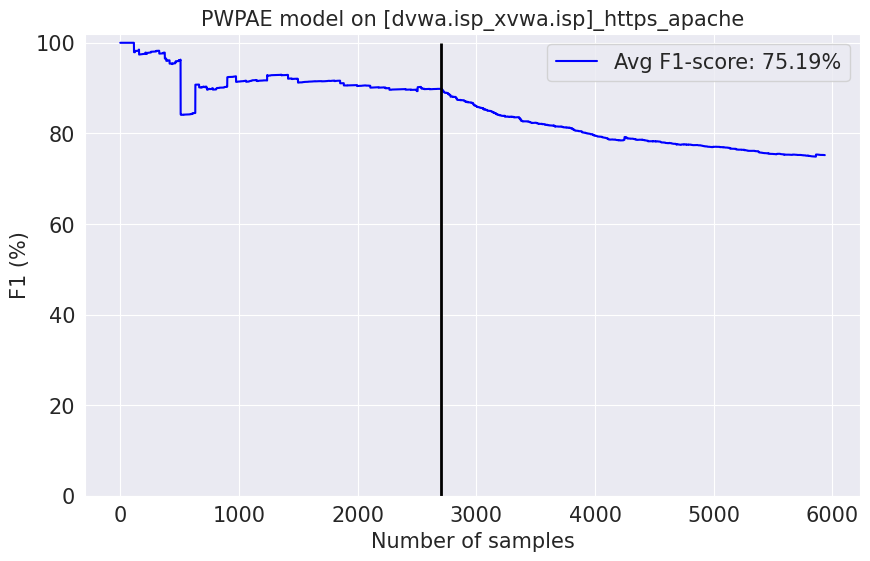

In [16]:
%%time
# Use the Performance Weighted Probability Averaging Ensemble (PWPAE) model 
name = "PWPAE model"
pwpae.fit(X_train, y_train)
t, m, dr, y_probs_old = pwpae.partial_fit(X_train, y_train)
t, m, dr, y_probs = pwpae.predict_test(X_test, y_test) # Learn the model on the dataset
acc_fig(t, m, name, dr) # Draw the figure of how the real-time accuracy changes with the number of samples

In [17]:
y_probs_old = np.array(y_probs_old)
y_probs = np.array(y_probs)

In [18]:
def drift_detect(drift, y_probs, is_est=False, log=True):
    dr = []
    est = []
    for i in range(y_probs.shape[0]):
        drift.update(y_probs[i])
        if drift.drift_detected:
            if log:
                print(f"Change detected at index {i}, input value: {y_probs[i]}")
            dr.append(i)
        if is_est:
            est.append(drift.estimation)
    return dr, est

In [19]:
drift = ADWIN()
dr_adwin, est = drift_detect(drift, y_probs, is_est=True)

Change detected at index 3199, input value: 0.11755296056569825


In [20]:
drift = KSWIN(alpha=0.0005, window_size=100, stat_size=30)
dr_KSWIN, _ = drift_detect(drift, y_probs, is_est=False)

In [21]:
drift = PageHinkley(min_instances=30, delta=0.0005, threshold=20.0, alpha=0.9999)
dr_pk, _ = drift_detect(drift, y_probs, is_est=False)

Change detected at index 3335, input value: 0.1281184747308673


In [22]:
def plot(point, data, est):
    # plt.rcParams.update({'font.size': 30})
    # plt.figure(1,figsize=(24,15)) 
    sns.set_style("darkgrid")
    plt.clf() 
    
    plt.plot(t,est,label='ADWIN estimation')

    for label, dr1 in data.items():
        for i in dr1:
            if i!=0:
                # plt.text(i-500, 100.8, 'Drift '+str(i), c = "red", fontsize = 25)
                plt.vlines(i, -1, 1, linewidth=2, linestyles="dashed", label=label, color=np.random.rand(i,3))
    
    plt.vlines(point, -1, 1, colors="black", linewidth=2)
            
    plt.legend(loc='lower right')
    plt.ylim(0.125, 0.250)
    plt.title('DVWA/XVWA',
              # fontsize=40
             )
    plt.suptitle("Обнаружение дрейфа на основе уверенности ", 
                 # fontsize=40
                )
    plt.xlabel('Samples')
    plt.ylabel('ADWIN estimation')
    plt.savefig(ARTIFACTS + f"estimation_drift_{TIMESTAMP}.png")

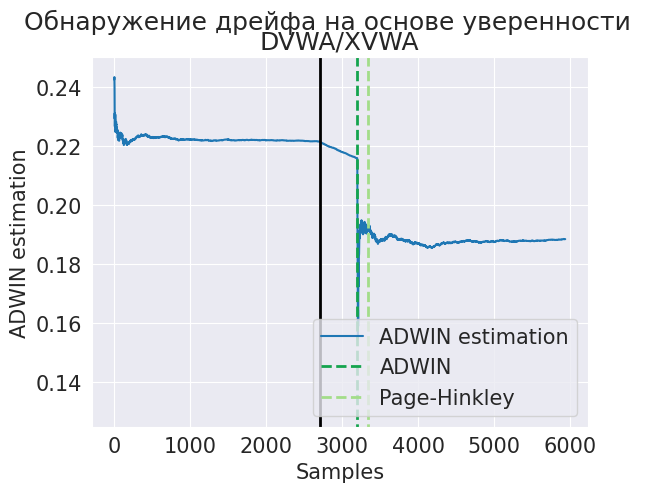

In [23]:
plot(point, {'ADWIN': dr_adwin, 'KSWIN': dr_KSWIN, 'Page-Hinkley': dr_pk}, est)

In [24]:
# plt.rcParams.update({'font.size': 30})
# plt.figure(1,figsize=(24,15)) 
# sns.set_style("darkgrid")
# plt.clf() 

# plt.plot(t,est,label='ADWIN estimation')
# # Draw the drift points/time
# for i in dr_adwin:
#     if i!=0:
#         # plt.text(i-500, 100.8, 'Drift '+str(i), c = "red", fontsize = 25)
#         plt.vlines(i, -1, 1, colors="red", linewidth=2, linestyles = "dashed", label='ADWIN')

# for i in dr_KSWIN:
#     if i!=0:
#         # plt.text(dr[i]-500, 100.8, 'Drift '+str(i), c = "red", fontsize = 25)
#         plt.vlines(i, -1, 1, colors="green", linewidth=2, linestyles = "dashed", label='KSWIN')

# for i in dr_pk:
#     if i!=0:
#         # plt.text(dr[i]-500, 100.8, 'Drift '+str(i), c = "red", fontsize = 25)
#         plt.vlines(i, -1, 1, colors="indigo", linewidth=2, linestyles = "dashed", label='Page-Hinkley')

# plt.vlines(point, -1, 1, colors="black", linewidth=2)
        
# plt.legend(loc='lower right')
# plt.ylim(0.125, 0.250)
# plt.title('DVWA/XVWA', fontsize=40)
# plt.suptitle("Обнаружение дрейфа на основе уверенности ", fontsize=40)
# plt.xlabel('Samples')
# plt.ylabel('ADWIN estimation')
# plt.savefig(ARTIFACTS + f"estimation_drift_{TIMESTAMP}.png")

# Подбор гиперпараметров для детектора

In [25]:
def drift_detector_estimate(dr, true_point):
    if len(dr) < 1:
        dr0 = 0
    else:
        dr0 = dr[0]
    return abs(true_point-dr0)

## ADWIN

In [26]:
import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

def objective(trial):
    delta = trial.suggest_float("delta", 1e-4, 1e-1, log=True)
    clock = trial.suggest_int("clock", 10, 100, log=True)
    max_buckets = trial.suggest_int("max_buckets", 1, 20, log=True)
    min_window_length = trial.suggest_int("min_window_length", 1, 20, log=True)

    drift = ADWIN(delta=delta, clock=clock, max_buckets=max_buckets, min_window_length=min_window_length)
    drs, est = drift_detect(drift, y_probs, is_est=True, log=False)
    delta = drift_detector_estimate(drs, point)
    return delta


study_adwin = optuna.create_study(
    direction="minimize",
    study_name=f"ADWIN_{datetime.datetime.now()}",
    storage="sqlite:///db.sqlite3"
)
study_adwin.optimize(objective, n_trials=1000, n_jobs=1, show_progress_bar=True)
print(f"Best value: {study_adwin.best_value} (params: {study_adwin.best_params})")
print(study_adwin.best_trial)

  0%|          | 0/1000 [00:00<?, ?it/s]

Best value: 134.0 (params: {'delta': 0.09978085681343124, 'clock': 17, 'max_buckets': 13, 'min_window_length': 6})
FrozenTrial(number=328, state=TrialState.COMPLETE, values=[134.0], datetime_start=datetime.datetime(2024, 9, 5, 17, 57, 12, 470010), datetime_complete=datetime.datetime(2024, 9, 5, 17, 57, 12, 640722), params={'delta': 0.09978085681343124, 'clock': 17, 'max_buckets': 13, 'min_window_length': 6}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'delta': FloatDistribution(high=0.1, log=True, low=0.0001, step=None), 'clock': IntDistribution(high=100, log=True, low=10, step=1), 'max_buckets': IntDistribution(high=20, log=True, low=1, step=1), 'min_window_length': IntDistribution(high=20, log=True, low=1, step=1)}, trial_id=13179, value=None)


In [27]:
optuna.visualization.plot_optimization_history(study_adwin)

In [28]:
optuna.visualization.plot_param_importances(study_adwin)

Change detected at index 2838, input value: 0.11120580442988597


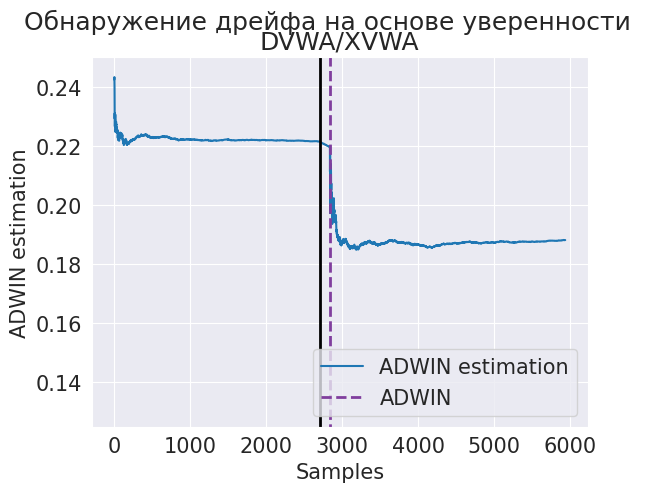

In [29]:
drift = ADWIN(**study_adwin.best_params)
dr_adwin, est = drift_detect(drift, y_probs, is_est=True)
plot(point, {'ADWIN': dr_adwin}, est)

## KSWIN

In [30]:
import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1e-1, log=True)
    window_size = trial.suggest_int("window_size", 50, 200, log=True)
    stat_size = trial.suggest_int("stat_size", 10, window_size//2, log=True)

    
    drift = KSWIN(alpha=alpha, window_size=window_size, stat_size=stat_size)
    drs, _ = drift_detect(drift, y_probs, is_est=False, log=False)
    delta = drift_detector_estimate(drs, point)
    return delta


study_kswin = optuna.create_study(
    direction="minimize",
    study_name=f"KSWIN_{datetime.datetime.now()}",
    storage="sqlite:///db.sqlite3"
)
study_kswin.optimize(objective, n_trials=100, n_jobs=1, show_progress_bar=True)
print(f"Best value: {study_kswin.best_value} (params: {study_kswin.best_params})")
print(study_kswin.best_trial)

  0%|          | 0/100 [00:00<?, ?it/s]

Best value: 14.0 (params: {'alpha': 0.002747962491684296, 'window_size': 151, 'stat_size': 51})
FrozenTrial(number=63, state=TrialState.COMPLETE, values=[14.0], datetime_start=datetime.datetime(2024, 9, 5, 18, 1, 58, 671746), datetime_complete=datetime.datetime(2024, 9, 5, 18, 2, 0, 852127), params={'alpha': 0.002747962491684296, 'window_size': 151, 'stat_size': 51}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'alpha': FloatDistribution(high=0.1, log=True, low=0.0001, step=None), 'window_size': IntDistribution(high=200, log=True, low=50, step=1), 'stat_size': IntDistribution(high=75, log=True, low=10, step=1)}, trial_id=13914, value=None)


In [31]:
optuna.visualization.plot_optimization_history(study_kswin)

In [32]:
optuna.visualization.plot_param_importances(study_kswin)

Change detected at index 2737, input value: 0.16173427494491124
Change detected at index 4229, input value: 0.22422058522060034


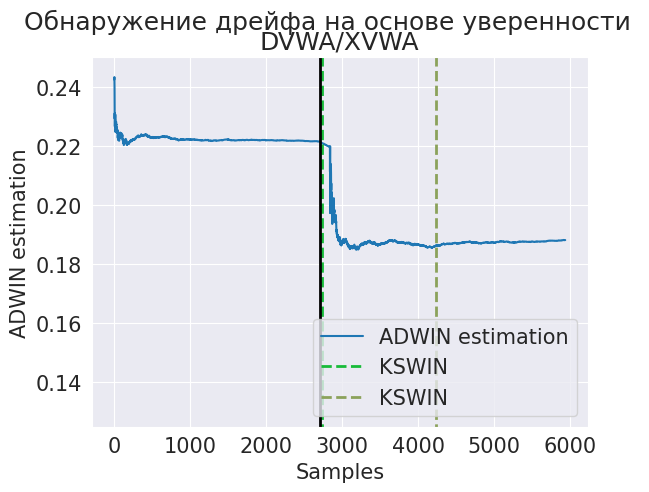

In [33]:
drift = KSWIN(**study_kswin.best_params)
dr_kswin, _ = drift_detect(drift, y_probs, is_est=False)
plot(point, {'KSWIN': dr_kswin}, est)

## Page-Hinkley 

In [34]:
import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

def objective(trial):
    min_instances = trial.suggest_float("min_instances", 5, 100, log=True)
    delta = trial.suggest_float("delta", 1e-4, 1e-1, log=True)
    threshold = trial.suggest_int("threshold", 10, 100, log=True)
    # alpha = trial.suggest_float("alpha", 0.9, 0.99999, log=True)
    alpha = 0.99999

    
    drift = PageHinkley(min_instances=min_instances, delta=delta, threshold=threshold, alpha=alpha)
    drs, _ = drift_detect(drift, y_probs, is_est=False, log=False)
    delta = drift_detector_estimate(drs, point)
    return delta


study_ph = optuna.create_study(
    direction="minimize",
    study_name=f"PageHinkley_{datetime.datetime.now()}",
    storage="sqlite:///db.sqlite3"
)
study_ph.optimize(objective, n_trials=1000, n_jobs=1, show_progress_bar=True)
print(f"Best value: {study_ph.best_value} (params: {study_ph.best_params})")
print(study_ph.best_trial)

  0%|          | 0/1000 [00:00<?, ?it/s]

Best value: 229.0 (params: {'min_instances': 10.298639183341638, 'delta': 0.00010032881012776433, 'threshold': 10})
FrozenTrial(number=118, state=TrialState.COMPLETE, values=[229.0], datetime_start=datetime.datetime(2024, 9, 5, 18, 3, 38, 788611), datetime_complete=datetime.datetime(2024, 9, 5, 18, 3, 38, 885239), params={'min_instances': 10.298639183341638, 'delta': 0.00010032881012776433, 'threshold': 10}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'min_instances': FloatDistribution(high=100.0, log=True, low=5.0, step=None), 'delta': FloatDistribution(high=0.1, log=True, low=0.0001, step=None), 'threshold': IntDistribution(high=100, log=True, low=10, step=1)}, trial_id=14069, value=None)


In [35]:
optuna.visualization.plot_optimization_history(study_ph)

In [36]:
optuna.visualization.plot_param_importances(study_ph)

Change detected at index 2941, input value: 0.11877523574358433


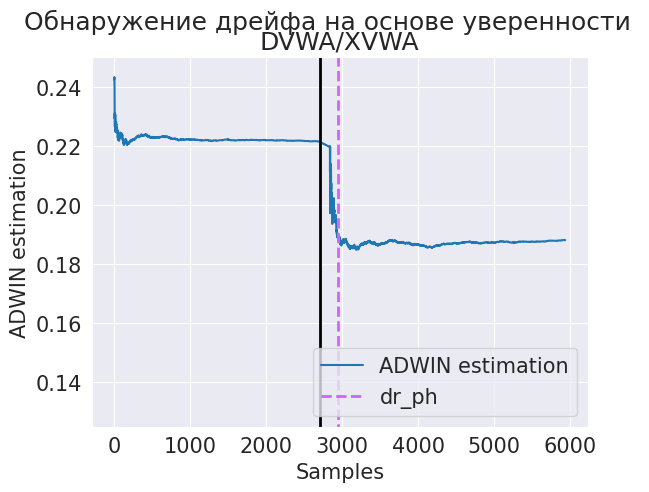

In [37]:
drift = PageHinkley(**study_ph.best_params)
dr_ph, _ = drift_detect(drift, y_probs, is_est=False)
plot(point, {'dr_ph': dr_ph}, est)

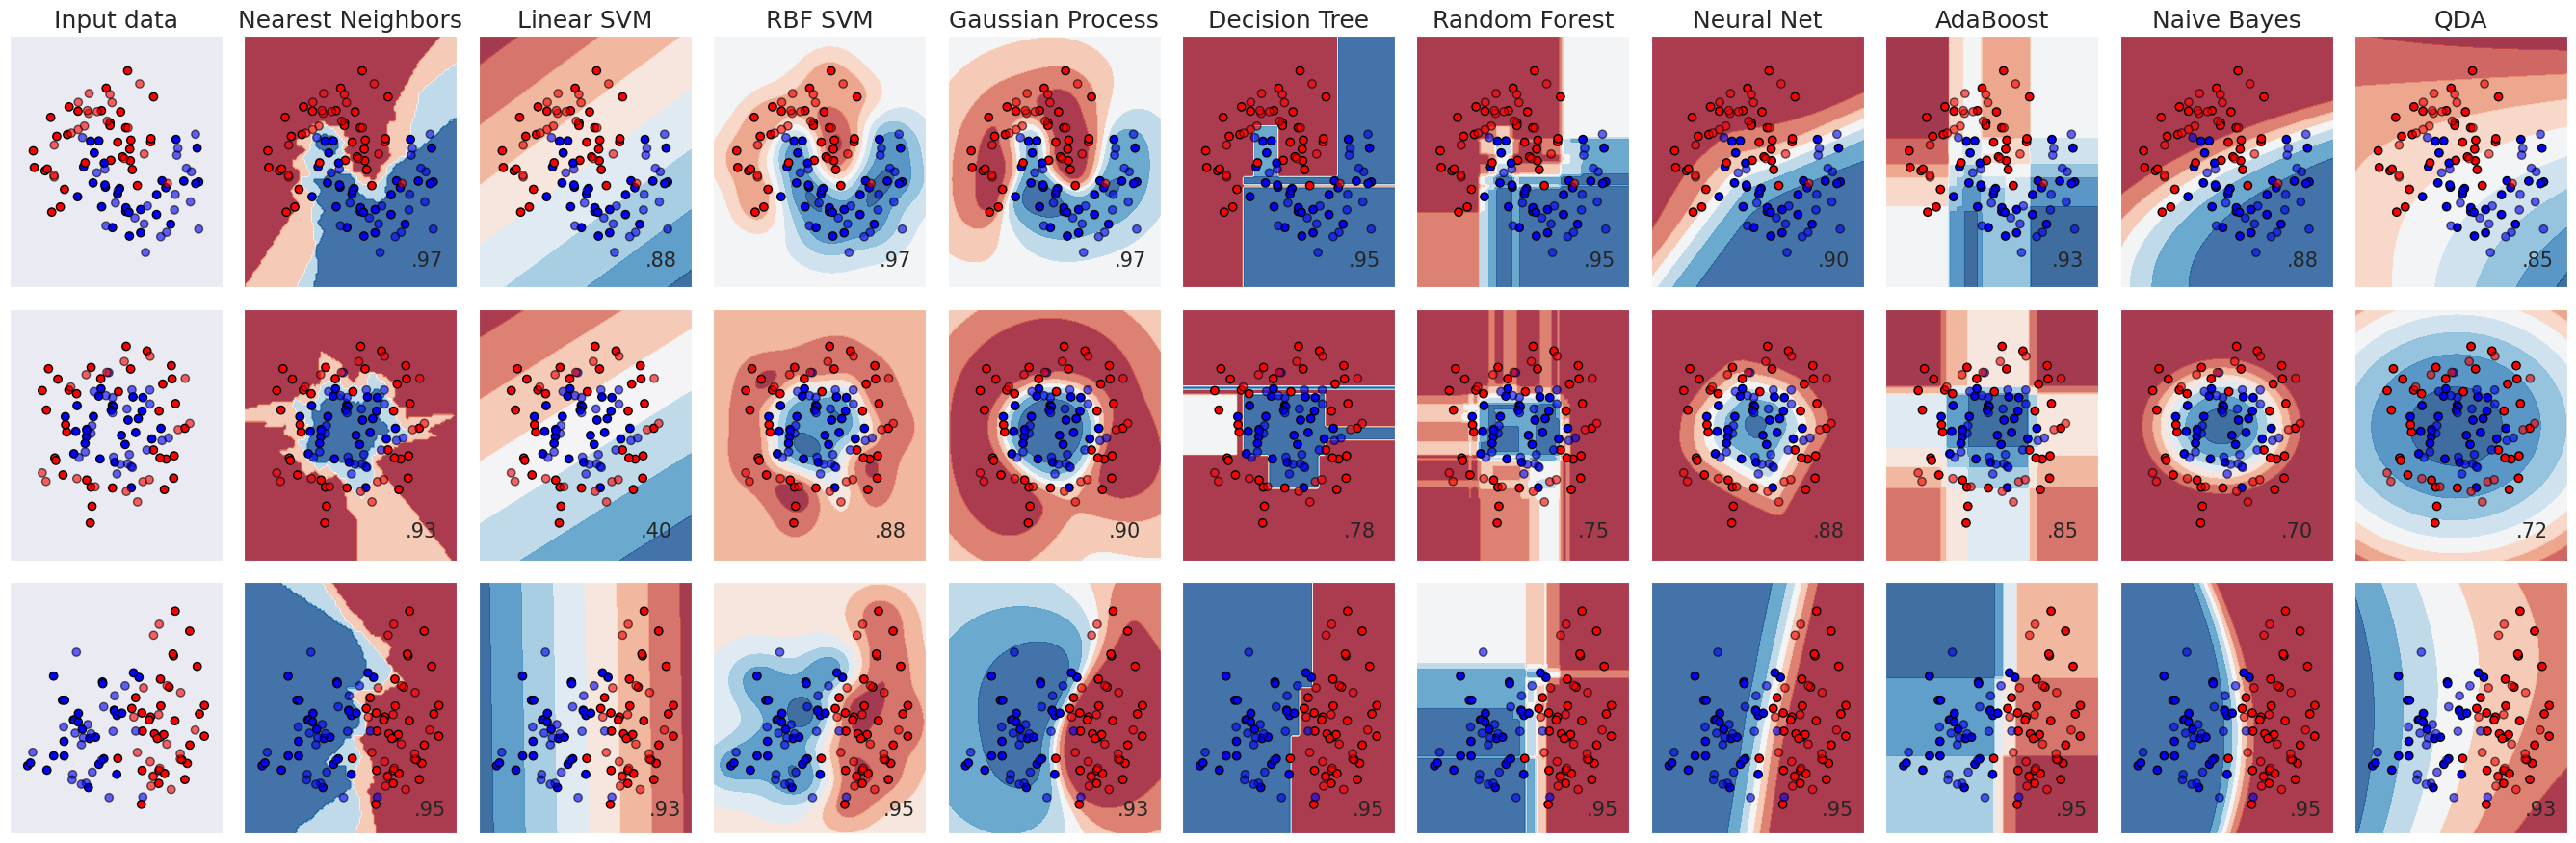

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

In [54]:
import datacompy
df1 = pd.read_csv(SOURCE_DATASET_FILENAME_D)
df2 = pd.read_csv(SOURCE_DATASET_FILENAME_X)
print(df1.describe())
print(df2.describe())

/tmp/ipykernel_2887070/146374132.py:2: DtypeWarning:

Columns (103) have mixed types. Specify dtype option on import or set low_memory=False.

/tmp/ipykernel_2887070/146374132.py:3: DtypeWarning:

Columns (103) have mixed types. Specify dtype option on import or set low_memory=False.



         Unnamed: 0  Session_Index   Source_Port  Destination_Port  Protocol  \
count  36549.000000   36549.000000  36549.000000           36549.0   36549.0   
mean    1436.076828    1436.146297  47637.457112             443.0       6.0   
std      994.515235     994.417545   7005.492509               0.0       0.0   
min        0.000000       0.000000  32770.000000             443.0       6.0   
25%      548.000000     548.000000  42804.000000             443.0       6.0   
50%     1325.000000    1325.000000  47704.000000             443.0       6.0   
75%     2238.000000    2238.000000  53018.000000             443.0       6.0   
max     4033.000000    4033.000000  60996.000000             443.0       6.0   

       Flow_Duration  Total_Fwd_Packets  Total_Backward_Packets  \
count   3.654900e+04       36549.000000            36549.000000   
mean    2.184510e+06           7.726285                4.857096   
std     1.728390e+06          11.916584                6.735201   
min     6.2

In [43]:
%pip install catboost

  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 75.0 MB/s eta 0:00:00:00:0100:01
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.1
    Uninstalling numpy-2.1.1:
      Successfully uninstalled numpy-2.1.1
Note: you may need to restart the kernel to use updated packages.


In [44]:
%pip install -U numpy

  Using cached numpy-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached numpy-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.1.1 which is incompatible.
river 0.21.2 requires numpy<2.0.0,>=1.23.0, but you have numpy 2.1.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
